In [1]:
import pandas

# Read data from file

In [2]:
user_artists_df = pandas.read_csv("./data/user_artists.dat", sep="\t")
user_artists_df

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


# Transform data to get adjacency matrix

The relation between any two users is specified as followed:
- If any two users share a common artist (through artistID), we said that they are connected.
- To reduce complexity, we only use unweighted graph, that is, all the weight are 1 if connected, and 0 otherwise.

In [3]:
artist_to_users_df = user_artists_df.groupby("artistID")["userID"].apply(set)
artist_to_users_df

artistID
1                                           {785, 34, 274}
2        {257, 1601, 580, 325, 1604, 135, 935, 397, 155...
3                                        {548, 2100, 1287}
4                                               {681, 510}
5                                              {557, 1551}
                               ...                        
18741                                                {454}
18742                                                {454}
18743                                                {454}
18744                                                {454}
18745                                                {585}
Name: userID, Length: 17632, dtype: object

In [4]:
user_adjacency_list = (
    user_artists_df.merge(artist_to_users_df, left_on="artistID", right_index=True, suffixes=("", "_list"))
    .groupby("userID")["userID_list"]
    .apply(lambda ids: set.union(*ids.array).difference({ids.name}))
)

user_adjacency_list

userID
2       {4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 20...
3       {896, 513, 1282, 517, 1289, 1931, 140, 1805, 7...
4       {2, 5, 6, 10, 11, 12, 13, 15, 16, 18, 20, 23, ...
5       {2, 4, 10, 11, 12, 13, 15, 17, 18, 20, 23, 24,...
6       {2048, 2, 4, 7, 8, 2056, 2061, 15, 2068, 2071,...
                              ...                        
2095    {1025, 1538, 262, 1289, 1545, 1553, 785, 1303,...
2096    {2, 4, 5, 10, 11, 12, 13, 15, 18, 20, 23, 27, ...
2097    {2, 4, 5, 10, 12, 13, 15, 17, 18, 20, 23, 24, ...
2099    {512, 3, 515, 517, 2055, 9, 12, 20, 1557, 1050...
2100    {1536, 512, 1025, 1538, 1026, 2053, 1030, 1545...
Name: userID_list, Length: 1892, dtype: object

In [5]:
user_adjacency_list[112]

set()

In [6]:
user_edge_list = user_adjacency_list.explode().dropna()
user_edge_list

userID
2          4
2          5
2          6
2          7
2          8
        ... 
2100     496
2100    1008
2100    1018
2100    1531
2100    2046
Name: userID_list, Length: 2028276, dtype: object

In [7]:
import numpy
import scipy

In [8]:
user_adjacency_matrix = scipy.sparse.csr_matrix(
    (numpy.ones(user_edge_list.shape), (user_edge_list.index, user_edge_list.array))
)

In [9]:
from libs.snmf import detect_community_structure_for_symmetric_adjacent_matrix

In [10]:
communities = detect_community_structure_for_symmetric_adjacent_matrix(user_adjacency_matrix.toarray() , expected_community_num_K=6, max_iter=200)

/Users/ducth/PycharmProjects/community-structure-identification-sem232/libs/i_divergence_DX_calculator.py:29: RuntimeWarning: divide by zero encountered in log
  matrix_a * numpy.log(numpy.divide(matrix_a, matrix_b, where=matrix_b != 0)),
/Users/ducth/PycharmProjects/community-structure-identification-sem232/libs/i_divergence_DX_calculator.py:29: RuntimeWarning: invalid value encountered in multiply
  matrix_a * numpy.log(numpy.divide(matrix_a, matrix_b, where=matrix_b != 0)),
/Users/ducth/PycharmProjects/community-structure-identification-sem232/libs/snmf.py:79: RuntimeWarning: invalid value encountered in divide
  return community_indicator_H / numpy.linalg.norm(community_indicator_H, axis=1, keepdims=True)


# Save result to file

In [ ]:
with open("data/communities.txt", "w") as result_file:
    for community in communities:
        result_file.write(repr(community))
        result_file.write("\n")

# Read from file to reduce complexity (for future runs)

In [2]:
with open("data/communities.txt", "r") as result_file:
    communities = [eval(line) for line in result_file]

# Filtering out lonely nodes

In [21]:
node_in_community = set()
for community in communities:
    node_in_community = node_in_community.union(community)
draw_nodes = [node for node in user_adjacency_list.index if node in node_in_community][:20]

In [28]:
user_adjacency_matrix[:20, :20].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1.

# Drawing graph

(-1.0, 1.0)

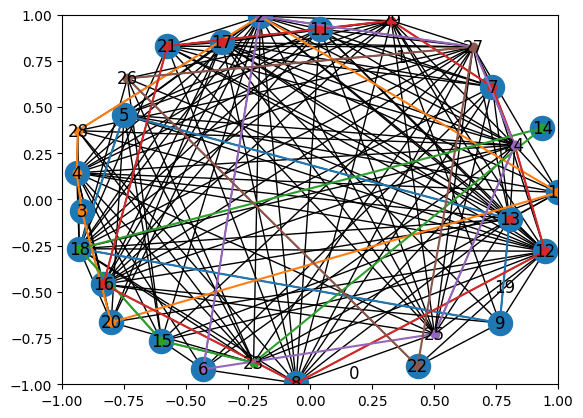

In [46]:
import matplotlib.pyplot as plt
import numpy
from scipy.spatial import ConvexHull
from matplotlib.collections import LineCollection
import networkx

graph = networkx.from_scipy_sparse_array(user_adjacency_matrix[:30, :30])


pos = networkx.spring_layout(graph, k=100)


boundary_list = []
for index, community in enumerate(communities):
    grouped_node_position = numpy.vstack([pos[node] for node in community if node < 30])
    boundary_list.append(ConvexHull(grouped_node_position))


ax = plt.subplot()
networkx.draw_networkx(
    graph,
    hide_ticks=False,
    with_labels=True,
    nodelist=draw_nodes,
    pos=pos,
    ax=ax,
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for index, boundary in enumerate(boundary_list):
    ax.plot(boundary.points[:, 0], boundary.points[:, 1], "o")
    line_segments = [boundary.points[simplex] for simplex in boundary.simplices]
    ax.add_collection(LineCollection(line_segments, colors=[colors[index]], linestyle="solid"))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)